#  NEURAL NETWORKS
# PROJECT 3: RNNs for Sentiment Analysis (with Attention)


Authors:

Marina Gómez Rey (100472836)

María Ángeles Magro Garrote (100472867)

Ángela Durán Pinto (100472766)

# Lab: RNNs for Sentiment Analysis (with Attention)


------------------------------------------------------

*Pablo M. Olmos pamartin@ing.uc3m.es*


------------------------------------------------------

In this notebook your goal is to take your solution to the previous Lab (Sentiment Analysis with RNNs) and add a simple attention layer before the classifier. Let $\mathbf{h}_0,\ldots,\mathbf{h}_\ell$ be the RNN output states ($\ell$ is the last state before feeding the garbage tokens):
- We will use $\mathbf{h}_\ell$ as the query ($\mathbf{q}=\mathbf{h}_\ell$)
- $\mathbf{h}_0,\ldots,\mathbf{h}_\ell$ are the keys
- Construct a two-layer MLP to construct the unnormalized weights $w_j=a(\mathbf{q},\mathbf{h}_j)$, $j=1,\ldots,\ell$. For the intermediate layer, use $tanh()$ activation.
- Normalized weights are given by $\mathbf{\alpha}=\text{Softmax}(w_1,\ldots,w_\ell)$.
- Input to the classifier is
\begin{align}
\mathbf{c} = \sum_{j=1}^{\ell}\alpha_j \mathbf{h}_j
\end{align}

Analyze if performance is improved and visualize the attention weights for a couple of cases.

**Note:** While you do not have to code much more given the solution of the previous lab, it is tricky to code the attention layer efficiently.

**Note 2:** Note we do NOT include in the attention module the states corresponding to processing the garbage token # to normalize lengths. It's important to keep this in mind. You can do this by masking the unnormalized weights $w_j$ if you compute then for the whole RNN output sequence.


## Prepare the Data

In [ ]:
import numpy as np
import pandas as pd
import spacy
from torch import nn
from torch import optim
import torch
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

In [ ]:
# Download language model

#!python -m spacy download en_core_web_md

In [ ]:
with open("Sentences.txt", "r", encoding="ISO-8859-1") as sentences:
    lines = sentences.readlines()

In [ ]:
phrases = [l.split('@')[0] for l in lines]
opinions = [l.split('@')[1] for l in lines]


def code_opinion(l):

    d = 0

    if (l=='negative\n'):

        d = 1

    elif (l=='positive\n'):

        d = 2

    return d

labels = np.array([code_opinion(l) for l in opinions])


In [ ]:
df = pd.DataFrame({"Phrase":phrases,
                  "Opinion":opinions})

df

,Phrase,Opinion
0,"According to Gran , the company has no plans t...",neutral\n
1,With the new production plant the company woul...,positive\n
2,"For the last quarter of 2010 , Componenta 's n...",positive\n
3,"In the third quarter of 2010 , net sales incre...",positive\n
4,Operating profit rose to EUR 13.1 mn from EUR ...,positive\n
...,...,...
5712,Operating result for the 12-month period decre...,negative\n
5713,HELSINKI Thomson Financial - Shares in Cargote...,negative\n
5714,LONDON MarketWatch -- Share prices ended lower...,negative\n
5715,Operating profit fell to EUR 35.4 mn from EUR ...,negative\n


In [ ]:
from sklearn.model_selection import train_test_split

labels_bin = labels.copy()

labels_bin[labels_bin==2] = 0

idx_data = np.arange(0,len(df),1)

# Separamos train de test
idx_train, idx_test, y_train, y_test = train_test_split(idx_data, labels_bin, test_size=0.2, random_state=0)

# Separamos train de val
idx_train, idx_val, y_train, y_val = train_test_split(idx_train, y_train, test_size=0.2, random_state=0)

acc_baseline_train = np.sum(y_train==0)/y_train.shape[0]

In [ ]:
nlp = spacy.load("en_core_web_md") # Language model

docs = [nlp(c) for c in phrases]

# We remove punctuation marks (.,;:?!...) and stopping words
def normalize(doc):

    return [w for w in doc if w.has_vector and not w.is_punct and not w.is_stop]

norm_docs = [normalize(d) for d in docs]

In [ ]:
# List with the length for each sentence

lengths = [len(d) for d in norm_docs]

# Maximum length (in train!)
max_l = np.max([lengths[d] for d in idx_train])

In [ ]:
# We add as many junk tokens (#) as needed to equalize the length of each sentence to max_l

garbage_token = nlp('#') # Junk token --> #

# We normalize the dataset

norm_docs_eq_length = [norm_docs[d]+[garbage_token]*(max_l-lengths[d]) for d in range(len(norm_docs))]

# Train documents

docs_train = [norm_docs_eq_length[d] for d in idx_train]

len_train = [lengths[d] for d in idx_train]

# Validation documents

docs_val = [norm_docs_eq_length[d] for d in idx_val]

len_val = [lengths[d] for d in idx_val]

# documentos test

docs_test = [norm_docs_eq_length[d] for d in idx_test]

len_test = [lengths[d] for d in idx_test]

## LSTM with Attention

The attention layer in an RNN-based Sentiment Analysis model is a mechanism that allows the model to focus on certain parts of the input sequence that are more relevant to the output. The key idea is to compute a weighted sum of the RNN output states, where the weights reflect the importance of each state in contributing to the final prediction.
<br>

**Inputs to the Attention Layer:**

- *RNN Output States (h):* These are the hidden states produced by the RNN when processing the input sequence.
- *Query (q):* It is last hidden state of the RNN (h_l). It acts as the "query" in the attention mechanism, providing a context to compute relevance scores for each hidden state.


**Attention Layer Operation**

 For each hidden state $h_j$, we want to compute a scalar relevance score $w_j$ that reflects how much attention should be given to that state. This score is derived from the query $q$ and the key $h_j$ using a simple two-layer MLP

- Multi-Layer Perceptron:

  The *first layer* computes an intermediate representation from the concatenation of q and $h_j$, using a tanh activation.By concatenating the query with each hidden state, we're enabling the model to explicitly learn the relationships between them. This can capture patterns or features that indicate how closely related each hidden state is to the query.
  The *second layer* maps this intermediate representation to a scalar value $w_j$.

- Apply Masking:

  As the input sequences have variable lengths and are padded to a common length, it's crucial to avoid attending to these padded tokens. By applying the mask to the unnormalized attention scores, we can effectively set the scores for these positions to a large negative value (-inf). This leads to zero attention weight after applying the softmax, ensuring that the attention mechanism focuses only on valid parts of the sequence.
  


- Normalization (Softmax):

 After computing the relevance scores, we normalize them using the softmax function to ensure that they sum to 1. The result is a set of attention weights $alpha_j$ for each hidden state.

**Output of the Attention Layer:**
- Context Vector (Weighted Sum):

 The final output of the attention layer is a context vector c, computed as the weighted sum of the hidden states using the normalized attention weights $alpha_j$. Mathematically:
 \begin{align}
\mathbf{c} = \sum_{j=1}^{\ell}\alpha_j \mathbf{h}_j
\end{align}



Finally, we compute the classification using a fully connected network which recieves as input the Context vector previously computed. The forward function returns the classification as well as the attention weights.

In [ ]:
class RNNAttention(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, prob=0.5):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.input_size = input_size
        self.n_layers = n_layers

        # LSTM layer
        self.rnn = nn.LSTM(input_size, hidden_dim, n_layers, dropout=prob, batch_first=True)

        # MLP for attention
        # First layer input dimension is the double because we are concatenating query and hidden state
        self.Linear = nn.Linear(2 * hidden_dim, hidden_dim )
        self.Tanh = nn.Tanh()
        # The Output dimension of the 2º layer is 1 because we want to get a scalar attention score wj
        self.Linear2 = nn.Linear(hidden_dim, 1)

        # Fully-connected layer
        self.fc1 = nn.Linear(hidden_dim, output_size)

        # Dropout layer
        self.dropout = nn.Dropout(p=prob)

        # LogSoftmax
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, lengths, h0=None):
        # Convert lengths to a PyTorch tensor
        lengths_tensor = torch.tensor(lengths)

        # Compute the RNN output: r_out are the keys, all the hidden states: h0,...,hl
        r_out, _ = self.rnn(x, h0)

        # The Query is the last hidden state, hl
        query = r_out[:, -1, :]

        # Compute the attention scores by concatenating the query with each hidden state
        unnormalized_weights = [] # Unnormalized weigths:  w0,...,wl
        for j in range(r_out.size(1)):  # For each hidden state hj
            input = torch.cat((query, r_out[:, j, :]), dim=1)  # Concatenate query and hidden state
            wj = self.Linear(input)
            wj = self.Tanh(wj)
            wj = self.Linear2(wj) # Now we have a scalar value

            #wj = self.attention_mlp(combined)  # Compute attention score using MLP
            unnormalized_weights.append(wj)

        unnormalized_weights = torch.cat(unnormalized_weights, dim=1)  # Concatenate all scores


        # Apply masking
        mask = torch.arange(x.size(1)).unsqueeze(0) >= lengths_tensor.unsqueeze(1)
        unnormalized_weights.masked_fill_(mask, float('-inf'))

        #mask = torch.arange(x.size(1)).unsqueeze(0) >= lengths.unsqueeze(1)
        #unnormalized_weights.masked_fill_(mask, float('-inf'))

        # Apply softmax to get normalized attention weights
        normalized_weights = F.softmax(unnormalized_weights, dim=1)

        # Compute the context vector
        context = torch.sum(normalized_weights.unsqueeze(2) * r_out, dim=1)

        # Classify using the context vector
        output = self.logsoftmax(self.fc1(self.dropout(context)))

        return output, normalized_weights



class RNN_with_train(RNNAttention):

    def __init__(self, input_size, output_size, hidden_dim, n_layers, prob=0.0, batch_size=50, lr=0.0005,
                 saved_files='./saved_models/RNN_sentiment_analysis'):
        super().__init__(input_size, output_size, hidden_dim, n_layers, prob)

        self.lr = lr  # Learning Rate
        self.optim = optim.Adam(self.parameters(), self.lr)  # Optimizer
        self.criterion = nn.NLLLoss()
        self.loss_during_training = []
        self.valid_loss_during_training = []
        self.batch_size = batch_size
        self.saved_files = saved_files

    def predict_proba(self, docs, lengths, Y=None):
        accuracy = 0.0
        with torch.no_grad():
            x_input = torch.Tensor([[w.vector for w in d] for d in docs])
            #logprobs, weigths = self.forward(x_input, lengths).detach().numpy()

            # Assuming your model's forward method returns a tuple with output and attention weights
            output, attention_weights = self.forward(x_input, lengths)

            # Detach each tensor and convert to numpy
            logprobs = output.detach().numpy()  # Detach and convert the output to numpy
            attention_weights = attention_weights.detach().numpy()  # Detach and convert attention weights to numpy

            if len(Y) > 0:
                accuracy = np.sum(np.argmax(logprobs, 1) == Y) / np.shape(Y)[0]
        return logprobs, accuracy

    def fit(self, docs_train, docs_val, Y, Yval, len_train, len_val, epochs=15, print_every=5):
        self.print_every = print_every
        self.epochs = epochs

        self.num_train = len(docs_train)
        self.num_batchs = np.floor(self.num_train / self.batch_size)
        self.num_val = len(docs_val)
        self.num_batchs_val = np.floor(self.num_val / self.batch_size)
        labels = torch.Tensor(Y).type(torch.LongTensor)
        labelsval = torch.Tensor(Yval).type(torch.LongTensor)

        for e in range(int(self.epochs)):
            self.train()
            idx = np.random.permutation(self.num_train)
            running_loss = 0.

            for i in range(int(self.num_batchs)):
                self.optim.zero_grad()
                idx_batch = idx[i * self.batch_size:(i + 1) * self.batch_size]
                idx_batch = [d for d in idx_batch if len_train[d] > 0]
                x_input = torch.Tensor([[w.vector for w in docs_train[d]] for d in idx_batch])
                out,weigths = self.forward(x_input, [len_train[d] for d in idx_batch])
                loss = self.criterion(out, labels[idx_batch])
                running_loss += loss.item()
                loss.backward()
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)
                self.optim.step()

            self.loss_during_training.append(running_loss / self.num_batchs)
            torch.save(self.state_dict(), self.saved_files + '_epoch_' + str(e) + '.pth')

            with torch.no_grad():
                self.eval()
                running_loss = 0.
                idx = np.random.permutation(self.num_val)
                running_loss = 0.

                for i in range(int(self.num_batchs_val)):
                    idx_batch = idx[i * self.batch_size:(i + 1) * self.batch_size]
                    idx_batch = [d for d in idx_batch if len_val[d] > 0]
                    x_input = torch.Tensor([[w.vector for w in docs_val[d]] for d in idx_batch])
                    out,weigths = self.forward(x_input, [len_val[d] for d in idx_batch])
                    loss = self.criterion(out, labelsval[idx_batch])
                    running_loss += loss.item()

                self.valid_loss_during_training.append(running_loss / self.num_batchs_val)

            #if e % self.print_every == 0:
            print(f"Training loss after {e} epochs: {self.loss_during_training[-1]}. Validation loss: {self.valid_loss_during_training[-1]}")


## Analyze Performance

First, we create an instance of our class defined above for LSTM with attention. Then we train our model. And finally, we evaluate the model.

In [ ]:
# Define the model with attention
my_RNN = RNN_with_train(input_size=300, output_size=2, hidden_dim=20, n_layers=1)

# Train the model
my_RNN.fit(docs_train, docs_val, y_train, y_val, len_train, len_val)

# Evaluate the model
logprobs_test, accuracy_test = my_RNN.predict_proba(docs_test, len_test, y_test)
print(f'Test Accuracy: {accuracy_test}')


Training loss after 0 epochs: 0.4624584062050467. Validation loss: 0.3289647524555524
Training loss after 1 epochs: 0.3286961494651559. Validation loss: 0.2900160178542137
Training loss after 2 epochs: 0.2911522561964923. Validation loss: 0.2730085692471928
Training loss after 3 epochs: 0.249873160091165. Validation loss: 0.23561498439974254
Training loss after 4 epochs: 0.20479477298994586. Validation loss: 0.21203987217611736
Training loss after 5 epochs: 0.16935416489635427. Validation loss: 0.19874499179422855
Training loss after 6 epochs: 0.14293886945672232. Validation loss: 0.17644411904944313
Training loss after 7 epochs: 0.12202636351528233. Validation loss: 0.1804354110111793
Training loss after 8 epochs: 0.10609785003000743. Validation loss: 0.17346559547715718
Training loss after 9 epochs: 0.09172093222708735. Validation loss: 0.17679664823744032
Training loss after 10 epochs: 0.08119610584761998. Validation loss: 0.16865303760601413
Training loss after 11 epochs: 0.0713689

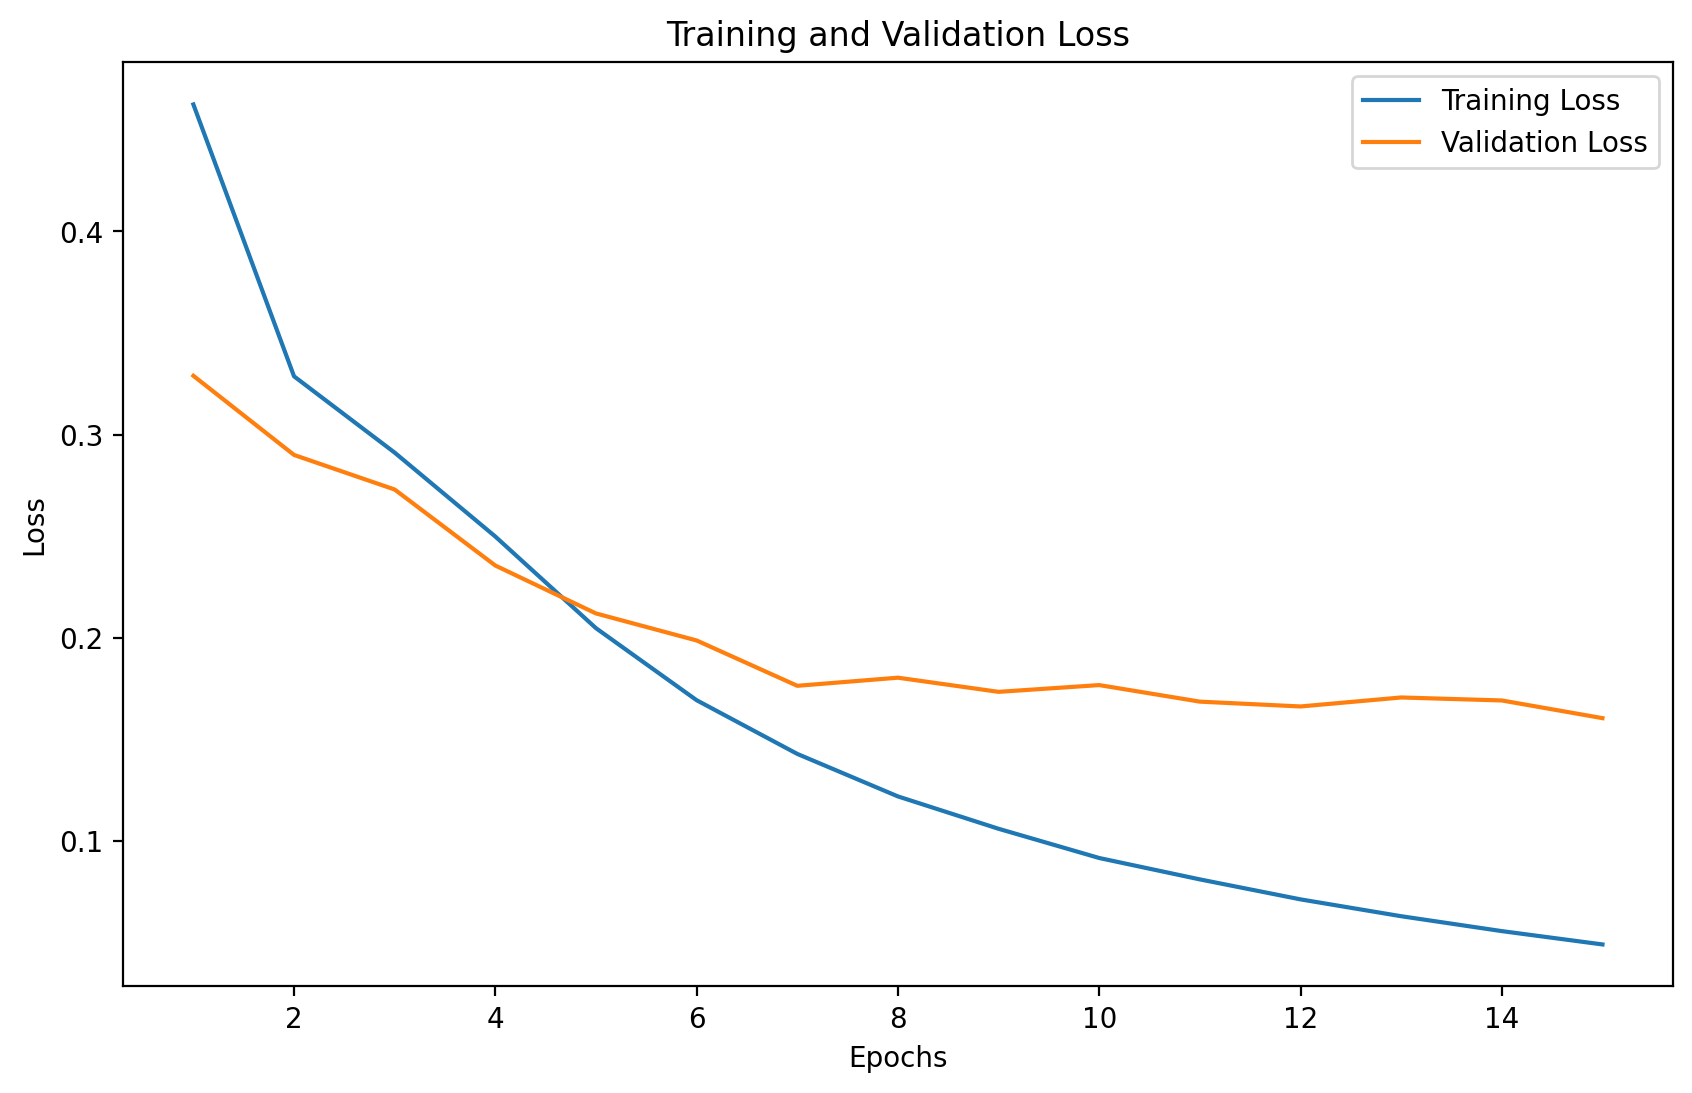

In [ ]:
# Plotting the train/val loss
plt.figure(figsize=(10, 6))
# Plotting the training loss over epochs
plt.plot(range(1, len(my_RNN.loss_during_training) + 1), my_RNN.loss_during_training, label='Training Loss')
# Plotting the validation loss over epochs
plt.plot(range(1, len(my_RNN.valid_loss_during_training) + 1), my_RNN.valid_loss_during_training, label='Validation Loss')
# Labels
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Results

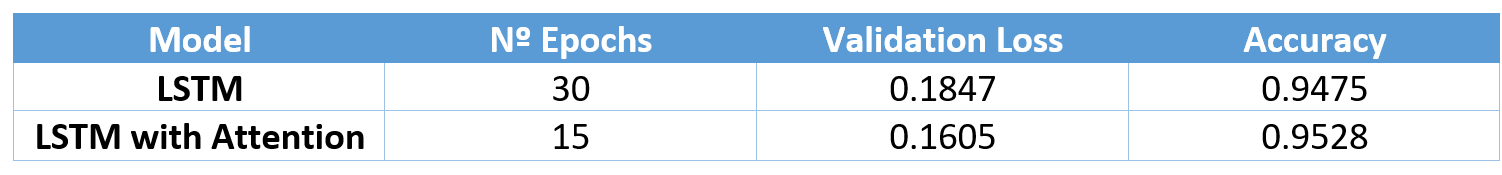

In comparing the results of the two models, the introduction of an attention mechanism has led to notable improvements in both validation loss and accuracy, despite a reduction in training epochs. The first model, a standard LSTM, was trained for 30 epochs and achieved a validation loss of 0.1847 with an accuracy of 94.75%. In contrast, the LSTM model with attention reached a validation loss of 0.1605 and an accuracy of 95.28% in just 15 epochs. This suggests that incorporating an attention layer not only enhances performance in terms of accuracy, demonstrating the model's ability to make more precise predictions, but also contributes to *faster convergence* as evidenced by the lower validation loss in fewer epochs. The results indicate that attention mechanisms can **improve the efficiency and efficacy** of recurrent neural network models, highlighting their potential for more effective sequence modeling tasks.

## Visualization weights of examples   

In this section, we focus on visualizing the attention weights of two different examples from a test dataset. By plotting the attention weights, we can gain insight into where the model is focusing within each sequence.

To visualize the attention weights, we select two examples from the test set, convert the input data to a format that can be processed by our RNN-based model, and run the model to obtain the attention weights for each example. The weights indicate the relative importance or relevance of each token in the sequence.
.

In [ ]:
# Visualize attention weights
idx_example_1 = 0  # index of the first example from the test set
idx_example_2 = 1  # index of the second example from the test set

# Convert input data to PyTorch tensors and move them to the appropriate device
x_input_example_1 = torch.Tensor([[w.vector for w in docs_test[idx_example_1]]])
x_input_example_2 = torch.Tensor([[w.vector for w in docs_test[idx_example_2]]])

# Get model output and attention weights
_, attention_weights_1 = my_RNN(x_input_example_1, [len_test[idx_example_1]])
_, attention_weights_2 = my_RNN(x_input_example_2, [len_test[idx_example_2]])


In [ ]:
print(attention_weights_1)
print(attention_weights_2)

tensor([[0.0313, 0.1281, 0.2774, 0.0328, 0.0311, 0.0185, 0.0728, 0.1302, 0.0382,
         0.0286, 0.2111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<SoftmaxBackward0>)
tensor([[0.0022, 0.0031, 0.0038, 0.0066, 0.1722, 0.0323, 0.0741, 0.0524, 0.0910,
         0.4342, 0.0949, 0.0301, 0.0023, 0.0008, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<SoftmaxBackward0>)


We check that the sum of the weights for each example should be approximately 1

In [ ]:
total_sum_1 = attention_weights_1.sum()
total_sum_2 = attention_weights_2.sum()

print("Total sum for example 1:", total_sum_1.item())
print("Total sum for example 2:", total_sum_2.item())


Total sum for example 1: 0.9999999403953552
Total sum for example 2: 1.0


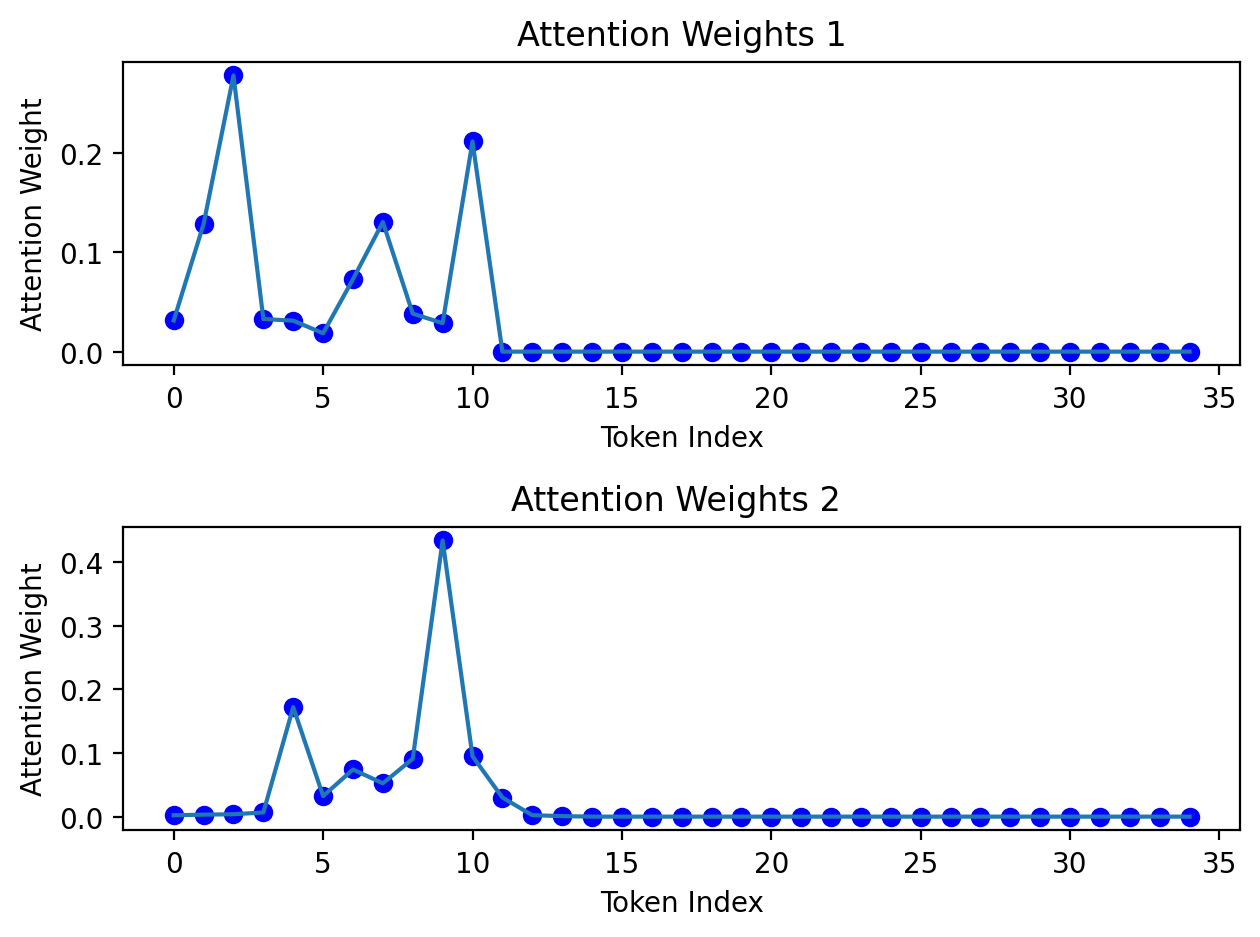

In [ ]:
import matplotlib.pyplot as plt

attention_weights_1_values = attention_weights_1.squeeze().tolist()
x1 = list(range(len(attention_weights_1_values)))

attention_weights_2_values = attention_weights_2.squeeze().tolist()
x2 = list(range(len(attention_weights_2_values)))

# First subplot
plt.subplot(2, 1, 1)
plt.plot(x1, attention_weights_1_values, 'bo')
plt.plot(x1, attention_weights_1_values)
plt.xlabel('Token Index')
plt.ylabel('Attention Weight')
plt.title('Attention Weights 1')

# Second subplot
plt.subplot(2, 1, 2)  # 2 rows, 1 column, subplot 2
plt.plot(x2, attention_weights_2_values, 'bo')
plt.plot(x2, attention_weights_2_values)
plt.xlabel('Token Index')
plt.ylabel('Attention Weight')
plt.title('Attention Weights 2 ')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


The attention weights show that the attention mechanism is functioning correctly. In both tensors, the weights at the end of the sequences are zero, indicating that these positions are padding tokens. Therefore, having zero weights for these positions confirms that the attention mechanism is correctly ignoring padding tokens, focusing instead on valid data.

In both examples, attention weights exhibit a non-uniform distribution, with some notable peaks, indicating a strong focus at these position.


These patterns of attention suggest that the model is effectively identifying and focusing on meaningful parts of the input sequences. The variable distribution of attention weights across different tokens can provide insights into the model's behavior and help in interpreting its decision-making process. This selective focus aligns with the expected behavior of a well-functioning attention mechanism in an RNN-based model, confirming that it can highlight the most important parts of an input sequence while ignoring non-relevant padding.

## Conclusion

The project demonstrated that incorporating an attention mechanism into an LSTM-based model for sentiment analysis improved both performance and interpretability. The LSTM with attention achieved a lower validation loss and higher accuracy in fewer epochs compared to the standard LSTM, indicating a more efficient convergence.

Visualization of attention weights showed that the model appropriately focused on relevant tokens while ignoring padding. This provided insights into which parts of the input sequences were most significant for predictions.

Overall, the use of attention in RNN-based models leads to enhanced performance and clearer interpretability, highlighting its value in tasks requiring selective focus on input sequences. The results suggest that attention mechanisms can boost efficiency and accuracy in deep learning models.